In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib.font_manager as fm

# 日本語フォントの設定
try:
    font_path = 'C:/Windows/Fonts/YuGothM.ttc'
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = font_prop.get_name()
except FileNotFoundError:
    print("日本語フォントが見つかりません。")

print("STEP 1: ライブラリのインポート完了")

STEP 1: ライブラリのインポート完了


In [7]:
# STEP 2: CSVファイルを読み込みます
# ★★★ 'retail_data.csv' の部分は、あなたの、実際のファイル名に、合わせてください ★★★
try:
    df = pd.read_csv('retail_data.csv', encoding="ISO-8859-1")
    print("STEP 2: CSVファイルの読み込み成功")
    display(df.head())
except FileNotFoundError:
    print("エラー：CSVファイルが見つかりません。ファイル名を確認してください。")

STEP 2: CSVファイルの読み込み成功


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [12]:
# STEP 3: データの前処理（最新・最終版）
print("STEP 3: データの前処理を開始...")

# 'Customer ID'が、空っぽの行を、"除外"した、"新しい"データフレームを、作成する
df_cleaned = df.dropna(subset=['Customer ID']).copy()
print("- 'Customer ID'の、欠損データを、処理しました。")

# 'InvoiceDate'を、「日時型」に、変換します
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])
print("- 'InvoiceDate'を、日時型に、変換しました。")

# 'Quantity'（数量）と'Price'（価格）が、0以下の、無効なデータを、"除外"します
df_cleaned = df_cleaned[(df_cleaned['Quantity'] > 0) & (df_cleaned['Price'] > 0)]
print("- 数量または、価格が、0以下の、無効なデータを、処理しました。")

# 'Customer ID'を、整数型に、変換します
df_cleaned['Customer ID'] = df_cleaned['Customer ID'].astype(int)
print("- 'Customer ID'を、整数型に、変換しました。")

print("\nデータの前処理が、完了しました。")
print(f"処理後の、データ数: {len(df_cleaned)}件")
display(df_cleaned.head())

STEP 3: データの前処理を開始...
- 'Customer ID'の、欠損データを、処理しました。
- 'InvoiceDate'を、日時型に、変換しました。
- 数量または、価格が、0以下の、無効なデータを、処理しました。
- 'Customer ID'を、整数型に、変換しました。

データの前処理が、完了しました。
処理後の、データ数: 805549件


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [13]:
# STEP 4: RFM分析の準備をします
print("STEP 4: RFM分析の準備を開始...")

# 'TotalPrice'（合計金額）という、新しい列を、作成します
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['Price']
print("- 'TotalPrice'列を、作成しました。")

# 分析の、"基準日"を、設定します
# データの、"最新の日付"の、"次の日"を、基準とします
snapshot_date = df_cleaned['InvoiceDate'].max() + dt.timedelta(days=1)
print(f"- 分析の、基準日: {snapshot_date}")

# 顧客ごとに、データを、集計します
rfm_data = df_cleaned.groupby(['Customer ID']).agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})

# 列の名前を、わかりやすく、変更します
rfm_data.rename(columns={'InvoiceDate': 'Recency',
                         'Invoice': 'Frequency',
                         'TotalPrice': 'MonetaryValue'}, inplace=True)

print("\nRFMの、基本計算が、完了しました。")
display(rfm_data.head()) # 計算結果の、"頭出し"を、確認します

STEP 4: RFM分析の準備を開始...
- 'TotalPrice'列を、作成しました。
- 分析の、基準日: 2011-12-10 12:50:00

RFMの、基本計算が、完了しました。


,Recency,Frequency,MonetaryValue
Customer ID,,,
12346,326,12,77556.46
12347,2,8,5633.32
12348,75,5,2019.40
12349,19,4,4428.69
12350,310,1,334.40


In [16]:
# STEP 5: RFMスコアを、算出します（改訂・頑健版）
print("STEP 5: RFMスコアの、算出を開始...")

# --- Recencyの、スコア化 ---
# 4等分で、スコアを、割り振る
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(rfm_data['Recency'], q=4, labels=r_labels, duplicates='drop')
rfm_data = rfm_data.assign(R=r_quartiles)
print("- Recencyスコアを、算出しました。")

# --- Frequencyの、スコア化（"絶対基準"を、導入）---
# Frequencyの、データが、"偏って"いるため、我々が、"手動"で、"基準"を、決める
def f_score(x):
    if x <= 1:
        return 1
    elif x <= 3:
        return 2
    elif x <= 5:
        return 3
    else:
        return 4

rfm_data['F'] = rfm_data['Frequency'].apply(f_score)
print("- Frequencyスコアを、算出しました。")

# --- MonetaryValueの、スコア化 ---
# 4等分で、スコアを、割り振る
m_labels = range(1, 5)
m_quartiles = pd.qcut(rfm_data['MonetaryValue'], q=4, labels=m_labels, duplicates='drop')
rfm_data = rfm_data.assign(M=m_quartiles)
print("- MonetaryValueスコアを、算出しました。")

print("\nRFMスコアの、算出が、完了しました。")
display(rfm_data.head()) # R, F, Mの、スコアが、追加されたことを、確認します

STEP 5: RFMスコアの、算出を開始...
- Recencyスコアを、算出しました。
- Frequencyスコアを、算出しました。
- MonetaryValueスコアを、算出しました。

RFMスコアの、算出が、完了しました。


,Recency,Frequency,MonetaryValue,R,F,M
Customer ID,,,,,,
12346,326,12,77556.46,2,4,4
12347,2,8,5633.32,4,4,4
12348,75,5,2019.40,3,3,3
12349,19,4,4428.69,4,3,4
12350,310,1,334.40,2,1,1


In [17]:
# STEP 6: RFMスコアを、組み合わせて、"顧客セグメント"を、定義します
print("STEP 6: 顧客セグメントの、定義を開始...")

# RスコアとFスコアを、文字列として、結合します
rfm_data['RF_Score'] = rfm_data['R'].astype(str) + rfm_data['F'].astype(str)

# RFスコアに、基づいて、"顧客"に、"名前"を、与えます
seg_map = {
    r'[1-2][1-2]': '離反予備軍',
    r'[1-2][3-4]': '要注意顧客',
    r'[3-4]1': '新規顧客',
    r'3[2-3]': '潜在顧客',
    r'4[2-3]': 'ロイヤル顧客',
    r'[3-4][3-4]': '優良顧客'
}

rfm_data['Segment'] = rfm_data['RF_Score'].replace(seg_map, regex=True)
print("顧客セグメントの、定義が、完了しました。")

display(rfm_data.head()) # 'Segment'列が、追加されたことを、確認します

STEP 6: 顧客セグメントの、定義を開始...
顧客セグメントの、定義が、完了しました。


,Recency,Frequency,MonetaryValue,R,F,M,RF_Score,Segment
Customer ID,,,,,,,,
12346,326,12,77556.46,2,4,4,24,要注意顧客
12347,2,8,5633.32,4,4,4,44,優良顧客
12348,75,5,2019.40,3,3,3,33,潜在顧客
12349,19,4,4428.69,4,3,4,43,ロイヤル顧客
12350,310,1,334.40,2,1,1,21,離反予備軍


STEP 7: 可視化と、画像の、保存を開始...

分析結果の、円グラフが、'static/images/segment_pie_chart.png'として、保存されました。


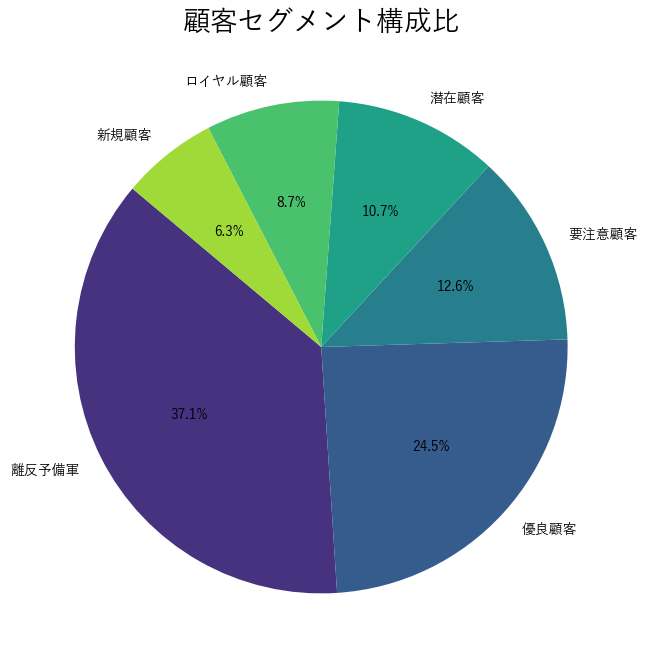

In [18]:
# STEP 7: 分析結果を、"円グラフ"で、可視化し、"画像"として、保存します
print("STEP 7: 可視化と、画像の、保存を開始...")

# セグメントごとの、顧客数を、計算します
segment_counts = rfm_data['Segment'].value_counts()

# グラフの、"見た目"を、設定します
plt.figure(figsize=(12, 8))
sns.set_palette('viridis')

# "円グラフ"を、描画します
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, textprops={'fontproperties': font_prop})

# グラフの、"タイトル"を、設定します
plt.title('顧客セグメント構成比', fontproperties=font_prop, fontsize=20)
plt.ylabel('') # 不要なラベルを、非表示に

# "static"と"images"という、フォルダを、作成する、おまじない
import os
if not os.path.exists('static/images'):
    os.makedirs('static/images')

# グラフを、"画像ファイル"として、保存します
plt.savefig('static/images/segment_pie_chart.png', bbox_inches='tight')

print("\n分析結果の、円グラフが、'static/images/segment_pie_chart.png'として、保存されました。")
plt.show() # グラフを、ノートブック上にも、表示します

In [20]:
# STEP 8: "決定木"分析のための、"新しい、武器"を、インポートします
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

print("STEP 8: 機械学習ライブラリ（Scikit-learn）の、インポート完了")

STEP 8: 機械学習ライブラリ（Scikit-learn）の、インポート完了


In [21]:
# STEP 9: "問題集（特徴量）"と"解答（ターゲット）"を、準備します
print("STEP 9: 訓練データと、テストデータの、準備を開始...")

# 我々が、"予測"したい、"答え"は、「優良顧客かどうか」です
# まず、「優良顧客」なら「1」、それ以外なら「0」という、シンプルな、"正解ラベル"を、作ります
rfm_data['is_top_customer'] = rfm_data['Segment'].apply(lambda x: 1 if x == '優良顧客' else 0)

# "問題集"として、R, F, Mの、"スコア"を、使います
X = rfm_data[['R', 'F', 'M']]

# "解答"として、先ほど、作った、"正解ラベル"を、使います
y = rfm_data['is_top_customer']

# "問題集"と"解答"を、「訓練用」と「テスト用」に、8:2の、割合で、分割します
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("訓練データと、テストデータの、準備が、完了しました。")
print(f"訓練データ数: {len(X_train)}件")
print(f"テストデータ数: {len(X_test)}件")

STEP 9: 訓練データと、テストデータの、準備を開始...
訓練データと、テストデータの、準備が、完了しました。
訓練データ数: 4702件
テストデータ数: 1176件


STEP 10: 決定木の、創造を開始...
- モデルの、学習が、完了しました。
- モデルの、正解率: 1.00

決定木の、画像が、'static/images/decision_tree.png'として、保存されました。


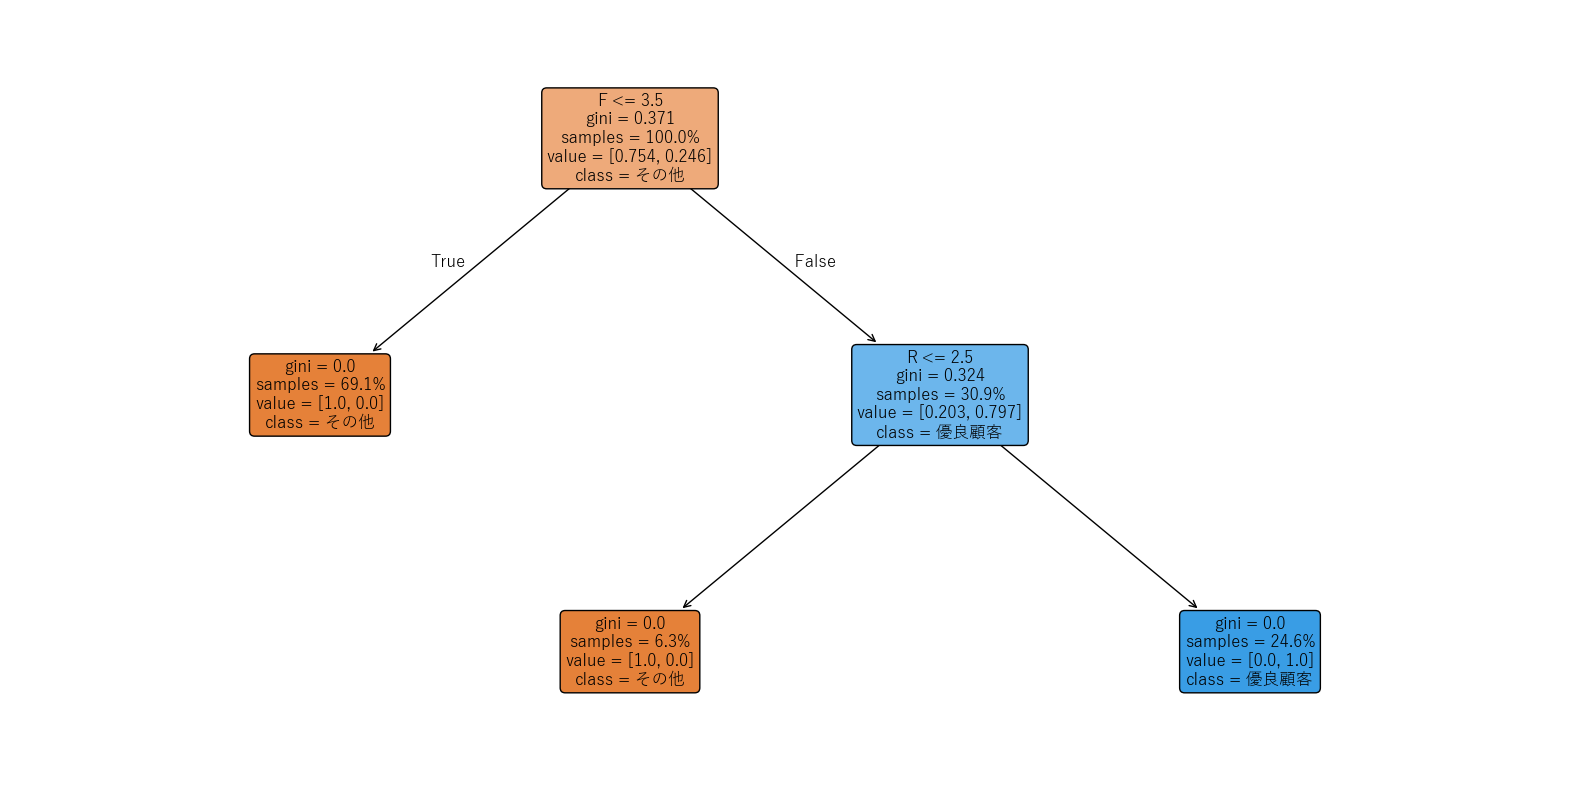

In [22]:
# STEP 10: "決定木"モデルを、"訓練"させ、"予測"し、"可視化"します
print("STEP 10: 決定木の、創造を開始...")

# "決定木"という、"名前"の、"空っぽ"の、AIモデルを、作ります
# （木の、深さは、最大3階層までに、制限し、シンプルに、します）
model = DecisionTreeClassifier(max_depth=3, random_state=42)

# "訓練用"の、"問題集"と"解答"を、AIに、"与え"、"学習"させます
model.fit(X_train, y_train)
print("- モデルの、学習が、完了しました。")

# 学習した、モデルに、「テスト用の、問題集」を、解かせて、"予測"させます
y_pred = model.predict(X_test)

# "AI"の、"予測"と、"本当の、答え"を、"比較"し、"正解率"を、計算します
accuracy = accuracy_score(y_test, y_pred)
print(f"- モデルの、正解率: {accuracy:.2f}")

# "学習"の、結果、"AI"が、"頭の中"に、作り上げた、"決定木"を、"可視化"します
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns, class_names=['その他', '優良顧客'], filled=True, rounded=True, fontsize=12, proportion=True)

# 決定木を、"画像"として、保存します
plt.savefig('static/images/decision_tree.png', bbox_inches='tight')
print("\n決定木の、画像が、'static/images/decision_tree.png'として、保存されました。")

plt.show()